# Description
This script can be used for an optimization with an cylinder as an initial geometry. The diameter from the cylinder is fixed.

In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._catenoid import *
from ddgclib._truncated_cone import *
from ddgclib._plotting import *


def curvature(v):
    F, nn = vectorise_vnn(v)
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i





In [2]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

# Functions

In [3]:
def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''

    r_l = d_l / 2
    r_u = d_u / 2

    t = 0  #  initial time (=constant)

    v_l = 0
    v_u = length +v_l
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)

    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        if v.x[2] == v_u:
            boundary_top.append(v)

    HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []



    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    i = 0


    while t < t_f:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge




        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)

            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))

            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        residual_iteration = residual_iteration +1
        iteration_list.append(residual_iteration)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        '''
        if i == 0:
            continue
        else:
            res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])

        '''



        res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])
        res_list.append(res)


        t = tau + t
        i = i+1
        print(i)


    return(HC, iteration_list, df_list_min, df_list_max,res_list,i)



In [4]:
'''
Function for calculating the volume of the mesh
'''
def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk




# Using the Function

In [5]:
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
refinement=3# NOTE: 2 is the minimum refinement needed for the complex to be manifold
d_l = 1 # radian on the lower side of the cone
d_u = 2 # diameter on the upper side of the cone
length = 5 # length of the cone
tau = 0.1    # Endtime for calculatio
t_f = 100 # final time of the time step

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d

dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma)
print(dummy_parameter[5])

HC = dummy_parameter[0]
iteration_list = dummy_parameter[1]
df_list_min = dummy_parameter[2]
df_list_max = dummy_parameter[3]
res_list     = dummy_parameter[4]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


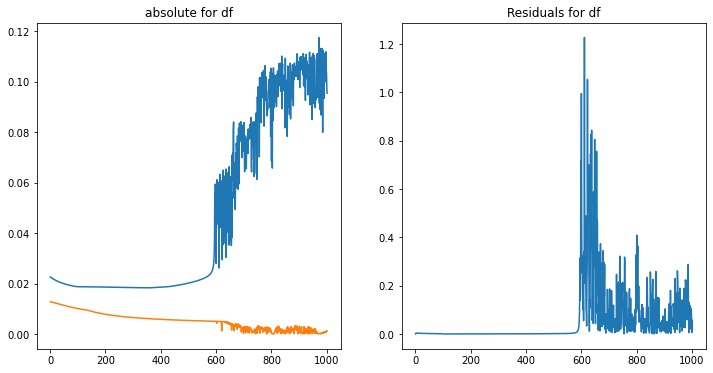

In [6]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)

ax[1].plot(iteration_list, res_list)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('absolute for df')
ax[1].set_title('Residuals for df')

fig.savefig('Residuals.png')

In [7]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

# Volume calculating Flo

In [49]:
V = 0
for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12

D:\02_Masterarbeit\03_Python\ddgclib\_curvaturesplay.py:1499: RuntimeWarning: invalid value encountered in longdouble_scalars
  HN_i = np.sum(HNdA_i) / np.sum(C_ij)


In [50]:
V

1.1147009635192056

In [51]:
def fun_V_analytic(r, v_l, v_u):
    V_an = np.pi/4*r**2*(v_u-v_l)
    return V_an

In [52]:
fun_V_analytic(1,-0.5,0.5)

0.7853981633974483

# Save and load from complexes

In [53]:
'''
Save and load don't work --> ask Stefan
'''
#HC.save_complex(fn='data.json')

"\nSave and load don't work --> ask Stefan\n"